In [1]:
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import random
from jax import grad, jit
from IPython.display import clear_output


lam = .2
num_params = 6

def psi(x, params):
    return params[0] * jnp.exp(-params[1] * (x + params[2])**2) + params[3] * jnp.exp(- params[4] * (x + params[5])**2)

def logpsi(x, params):
    return jnp.log(psi(x, params))
# compute the partial with respect to x
ddpsi = jit(grad(jit(grad(psi, 0, allow_int=True)), 0, allow_int=True))

partials = jit(grad(logpsi, argnums=1))

def V(x):
    return 1/2 * x**2 + lam * x**4

def Hpsi(x, params):
    return V(x) * psi(x, params) - 1/2 * ddpsi(float(x), params)

def grad_log_psi(x_inp, params):
    # this will return a vector of length len(params)
    grad = np.zeros(len(params))
    # now add in the derivatives with respect to each variable
    for i in range(num_params):
        grad[i] = partials(float(x_inp), params)[i]
    return grad

def sample(params, num_samples):
    outputs = []
    x_t = 0
    for _ in range(num_samples):
        x_prime = x_t + random.uniform(-1,1)
        if (random.uniform(0,1) < psi(x_prime, params)**2/psi(x_t,params)**2):
            x_t = x_prime
        outputs.append(x_t)
    return outputs

def avg_energy(params, N=10**3):
    # get N sampled points
    samples = sample(params, N)
    # apply the function to every point
    applied = [(1/psi(x_a, params) * Hpsi(x_a, params)) for x_a in samples]
    return 1/N * sum(applied)

def gradient(params, N):
    samples = sample(params, N)
    # now compute the 3 different averages
    energy_exp = 1/N * sum([(1/psi(x_a, params) * Hpsi(x_a, params)) for x_a in samples])
    print("Average Energy: " + str(energy_exp))
    gradlogpsi_exp = 1/N * sum([grad_log_psi(x_a, params) for x_a in samples], 0)
    both_exp = 1/N * sum([(1/psi(x_a, params) * grad_log_psi(x_a, params) * Hpsi(x_a, params)) for x_a in samples], 0)
    return (2 * both_exp - 2 * energy_exp * gradlogpsi_exp)

# write a gradient descent optimizer for the average energy
def grad_opt(start_params, learning_rate=.1, max_iterations=100, tolerance=.001, N=10**3):
    # pick the starting position
    params = start_params
    hist = []
    # iterate until we run out of iterations or less than tolerance
    for it in range(max_iterations):
        clear_output(wait=True)
        # compute the gradient at that point
        diff = np.asarray((learning_rate * gradient(params, N)))
        if all((abs(val) < tolerance) for val in diff):
            print("All under tolerance")
            return hist
        # make a step in the direction opposite the gradient
        params = params - diff
        # print(params)
        hist.append(params)
    return hist

In [2]:
start = [.5, .5, 1.0,.5, .2, 0.1]

hist = grad_opt(start)
optd = hist[-1]

Average Energy: 0.60639435
All under tolerance


[ 0.18423317  0.79533803  0.5413684   0.69511464  0.74802265 -0.13086132]
Minimized Energy: 0.6023044586181641


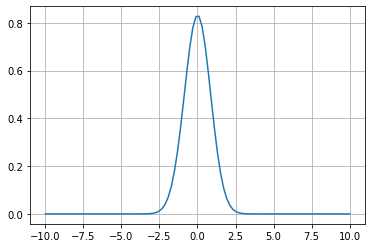

In [3]:
#plot the wavefunction
print(optd)
x_vals = np.linspace(-10,10,100)
y = [psi(x_a, optd) for x_a in x_vals]
v = [V(x_a) for x_a in x_vals]
comp_avg = avg_energy(optd, 10**3)
print(f"Minimized Energy: {comp_avg}")
# true_energy = fifth_corrections()
# print(f"True GS Energy: {true_energy}")
# pdiff = 100*(true_energy -  comp_avg)/true_energy
# print(f"Percent Difference: {pdiff}")
plt.plot(x_vals,y)
#plt.plot(x_vals,v)
plt.grid()
plt.show()

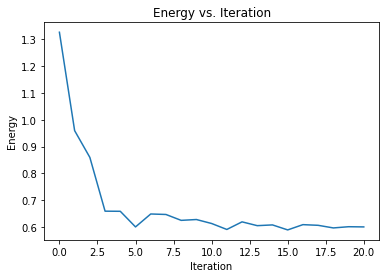

In [144]:
en = [avg_energy(x) for x in hist]
plt.plot(en)
plt.title("Energy vs. Iteration")
plt.ylabel("Energy")
plt.xlabel("Iteration")
plt.show()